In [ ]:
#pip install pytorch_lightning

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

np.random.seed(11)

# Данные

Беру информацию об оценках фильмов пользователями ratings.csv из полного датасета MovieLens

In [ ]:
ratings = pd.read_csv('ratings.csv', parse_dates=['timestamp'])
ratings = ratings.iloc[:-1]
ratings['movieId'] = ratings['movieId'].apply(int)
ratings['userId']  = ratings['userId'].apply(int)

Возьму только 7000 случайных уникальных пользователей.

In [ ]:
random_users = np.random.choice(ratings['userId'].unique(), 
                                size=7000, 
                                replace=False)

ratings = ratings.loc[ratings['userId'].isin(random_users)]

Для каждого пользователя в валидационную выборку беру его самую последнюю оценку, а все остальные оценки этого пользователя используем в обучающей выборке. Это позволит избежать заглядывания в будущее. Я не хочу случайно  разбивать данные в рекомендательной системе, так как порядок оценок пользователя важен! Он отражает текущие предпочтения пользователя и изменение интересов  со временем. 


In [ ]:
ratings['rank_latest'] = ratings.groupby(['userId'])['timestamp'] \
                                .rank(method='first', ascending=False)

train_ratings = ratings[ratings['rank_latest'] != 1]
test_ratings = ratings[ratings['rank_latest'] == 1]

train_ratings = train_ratings[['userId', 'movieId', 'rating']]
test_ratings = test_ratings[['userId', 'movieId', 'rating']]

# Построение модели

Буду предсказывать будущие просмотры пользователя, а не конкретную оценку фильма. Для этого я преобразую оценки в бинарные значения: 1 - если пользователь взаимодействовал с фильмом, и 0 - если не взаимодействовал.

Однако, если использовать такую разметку, то получится сильно разреженная матрица, почти все вхождения которой - нули, поэтому я для каждой "1" случайным образом выбираю 3 негативные оценки.


Создам класс для работы с данными.

In [ ]:
class DataHolder(Dataset):
   
    def __init__(self, ratings, all_movies):
        self.users, self.movies, self.labels = self.get_dataset(ratings, all_movies)

    def get_dataset(self, ratings, all_movies):
        users, movies, labels = [], [], []

        # множество пар взаимодействий пользователей с фильмами
        user_movie_set = set(zip(ratings['userId'], ratings['movieId']))

        # на каждую оценку пользователя генерирую 3 негативные оценки
        num_negatives = 3
        for u, i in user_movie_set:
            users.append(u)
            movies.append(i)
            labels.append(1)
            for _ in range(num_negatives):
                # выбираю рандомный фильм
                negative_movie = np.random.choice(all_movies)
                # проверяю, что пользователь не взаимодействовал с этим фильмом
                while (u, negative_movie) in user_movie_set:
                    negative_movie = np.random.choice(all_movies)
                users.append(u)
                movies.append(negative_movie)
                labels.append(0)

        return torch.tensor(users), torch.tensor(movies), torch.tensor(labels)

    def __len__(self):
        return len(self.users)
  
    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.labels[idx]

Архитектуру модели лучше покажу с помощью схемы, чем словами:

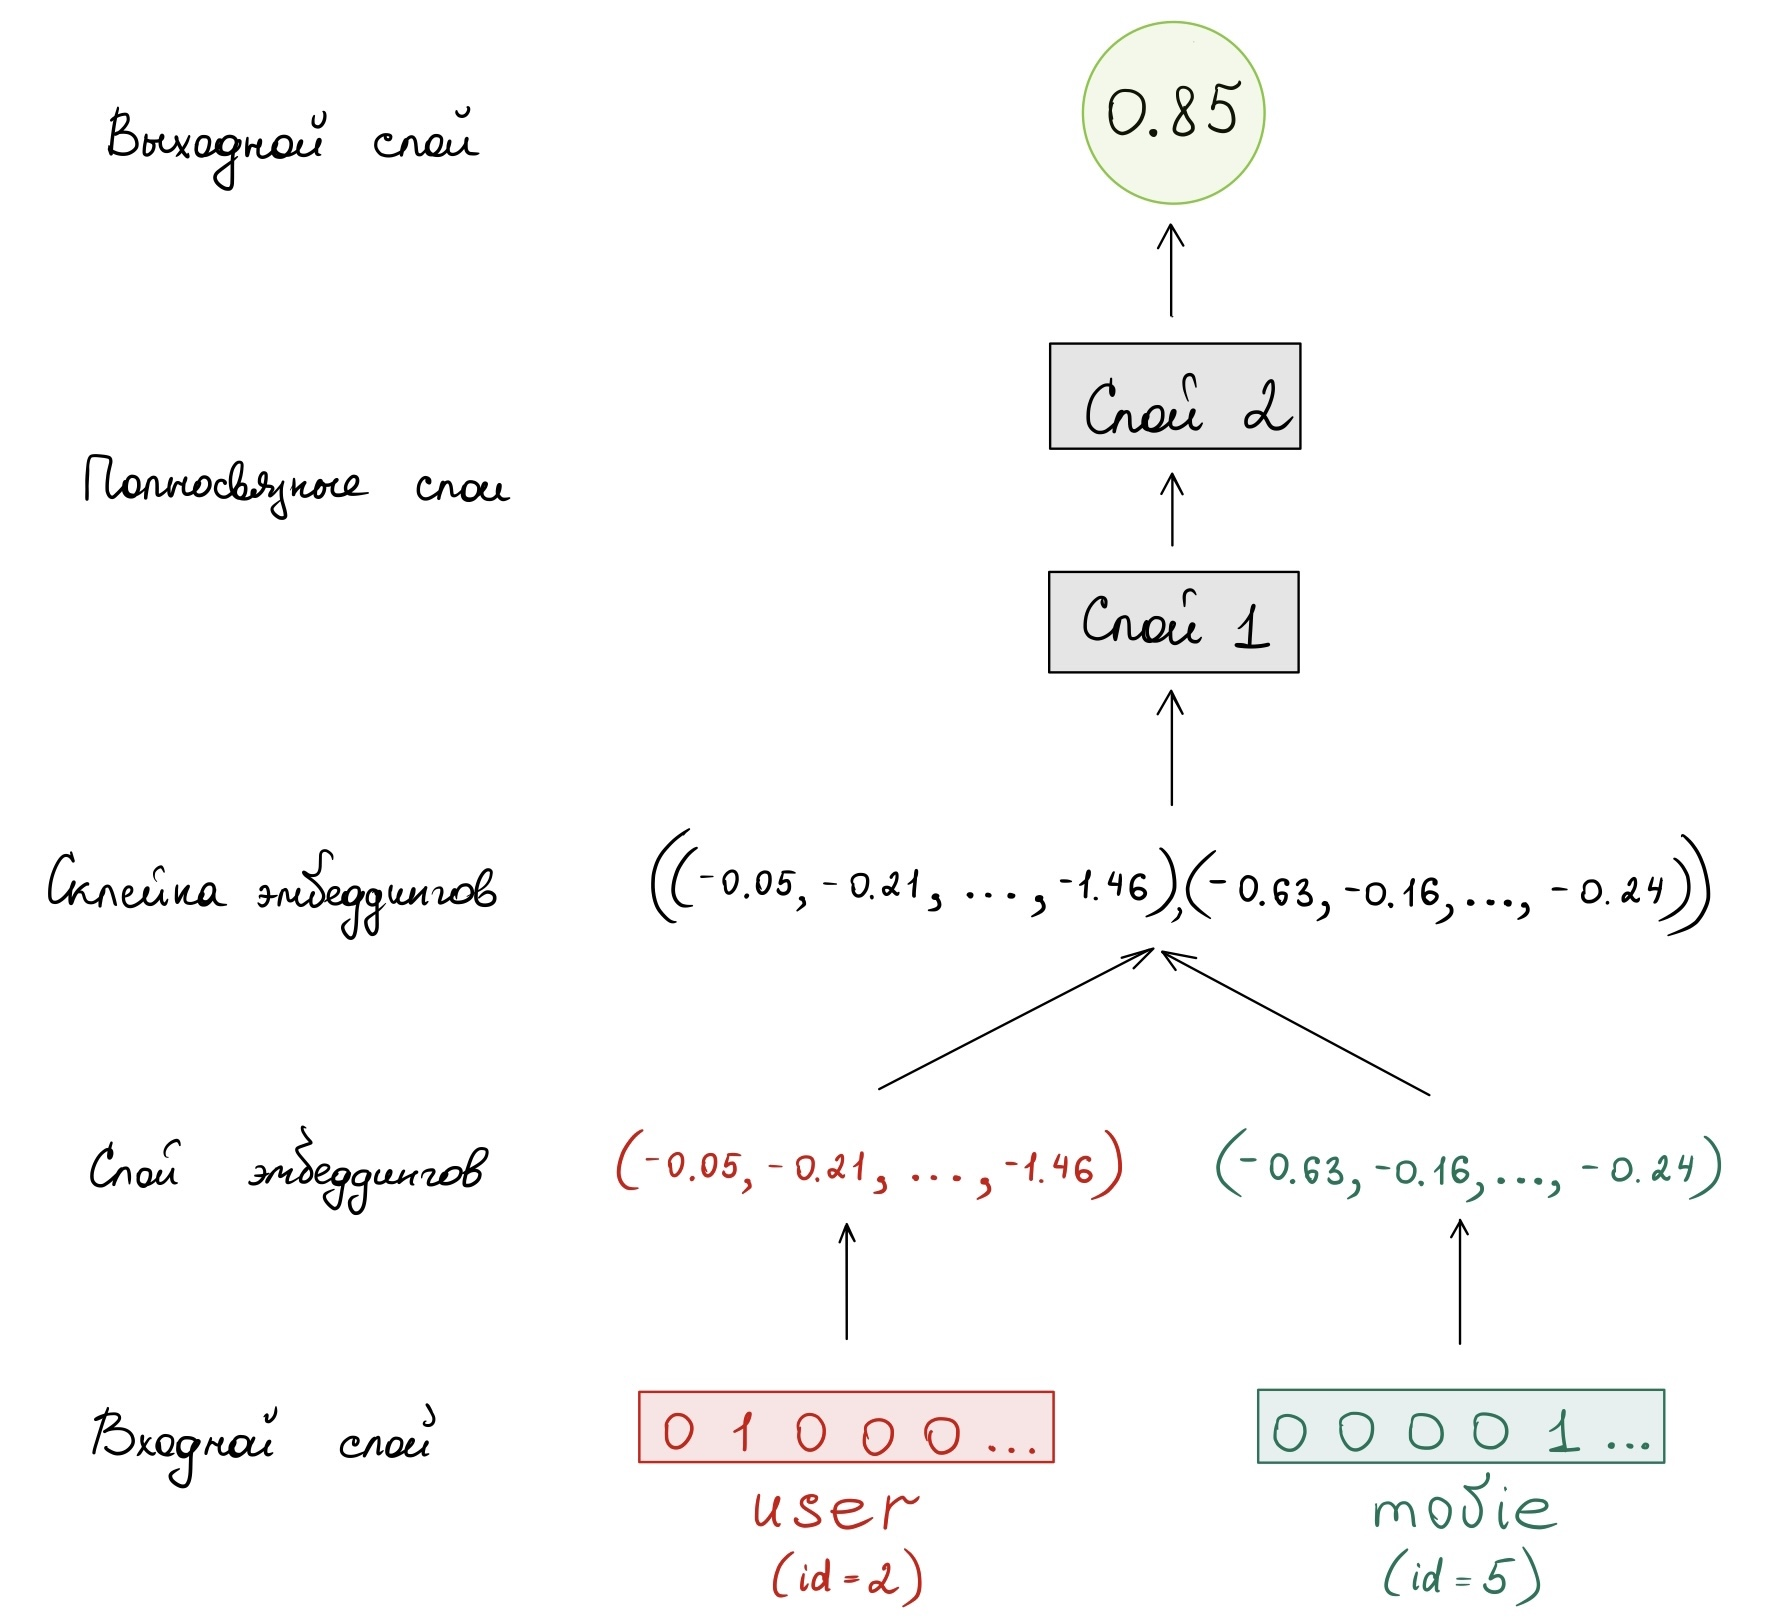

In [ ]:
class CollaborativeFiltering(pl.LightningModule):
  
    def __init__(self, num_users, num_movies, ratings, all_movies):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.movie_embedding = nn.Embedding(num_embeddings=num_movies, embedding_dim=8)
        self.linear1 = nn.Linear(in_features=16, out_features=64)
        self.linear2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.ratings = ratings
        self.all_movies = all_movies
    
    def forward(self, user_input, movie_input):
        
        # пропускаем через слои эмбеддинга
        user_embedded = self.user_embedding(user_input)
        movie_embedded = self.movie_embedding(movie_input)

        # склеивание двух слоев эмбеддинга
        vector = torch.cat([user_embedded, movie_embedded], dim=-1)

        # пропускаем через полносвязные слои
        vector = nn.ReLU()(self.linear1(vector))
        vector = nn.ReLU()(self.linear2(vector))

        # выходной слой - получаем наиболее вероятный класс (0 или 1)
        pred = nn.Sigmoid()(self.output(vector))

        return pred
        
    def get_embeddings(self, user_input, movie_input):
        return  self.user_embedding(user_input), self.movie_embedding(movie_input)

    def training_step(self, batch, batch_idx):
        user_input, movie_input, labels = batch
        predicted_labels = self(user_input, movie_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(DataHolder(self.ratings, self.all_movies),
                          batch_size=512, num_workers=4)

In [ ]:
# инициализация модели
num_users = ratings['userId'].max()+1
num_movies = ratings['movieId'].max()+1
all_movies = ratings['movieId'].unique()

model = CollaborativeFiltering(num_users, num_movies, train_ratings, all_movies)

Пришло время обучить модель!

In [ ]:
trainer = pl.Trainer(
    max_epochs=5,
    accelerator='gpu',
    reload_dataloaders_every_n_epochs=1, 
    # создаю новый случайно выбранный набор негативных выборок для каждой эпохи 
    logger=False,
)

trainer.fit(model)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 167 K 
1 | item_embedding | Embedding | 1.6 M 
2 | fc1            | Linear    | 1.1 K 
3 | fc2            | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Hit Ratio @ 10 - это метрика, которая измеряет, как часто в топ-10 рекомендованных объектов присутствует тот, который пользователь уже выбрал или просмотрел. Другими словами, HR@10 оценивает долю случаев, когда рекомендованный объект является интересным для пользователя и попадает в первые 10 рекомендаций.

Я выбрала метрику HR@10 для оценки качества потому что она является простой метрикой, которая учитывает только факт наличия рекомендации в топ-10,  и позволяет оценить качество модели с точки зрения её способности рекомендовать пользователю релевантные  фильмы.

In [ ]:
# пары пользователь-фильм для теста
test_user_movie_set = set(zip(test_ratings['userId'], test_ratings['movieId']))

# все фильмы, с которыми взаимодействовали пользователи
user_interacted_movies = ratings.groupby('userId')['movieId'].apply(list).to_dict()


Для каждого пользователя выбираю 99 фильмов, с которыми он не взаимодействовал
$⇒$ добавляю к ним валидационный фильм 
$⇒$ запускаю модель на этих 100 фильмах 
$⇒$ ​​ранжирую фильмы (в соответствии с их предсказанными вероятностями) $⇒$ беру 10 лучших элементов из списка из 100 элементов $⇒$ если валидационный фильм присутствует в топ-10 -- это hit $⇒$ повторяю для всех пользователей 

In [ ]:
hits = []
for (u,i) in tqdm(test_user_movie_set):
    interacted_movies = user_interacted_movies[u]
    not_interacted_movies = set(all_movies) - set(interacted_movies)
    selected_not_interacted = list(np.random.choice(list(not_interacted_movies), 99))
    test_movies = selected_not_interacted + [i]
    
    predicted_labels = np.squeeze(model(torch.tensor([u]*100), 
                                        torch.tensor(test_movies)).detach().numpy())
    
    top10_movies = [test_movies[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
    if i in top10_movies:
        hits.append(1)
    else:
        hits.append(0)
        
# Hit Ratio равен среднему количеству попаданий
print("Hit Ratio @ 10 = {:.2f}".format(np.average(hits)))

  0%|          | 0/7000 [00:00<?, ?it/s]

Hit Ratio @ 10 = 0.78


$\Rightarrow$ 78% пользователей был рекомендован действительно актуальный фильм (тестовый фильм, с которым они взаимодействовали)

# приложения

## чуть-чуть перебираю параметры ручками

(это запускать не нужно)

In [ ]:
print("embeddings dim = 8, num_neg = 3, HR@10 = {:.3f}".format(np.average(hits)))

embeddings dim = 8, num_neg = 3, HR@10 = 0.779


In [ ]:
print("embeddings dim = 8, num_neg = 4, HR@10 = {:.3f}".format(np.average(hits)))

embeddings dim = 8, num_neg = 4, HR@10 = 0.769


In [ ]:
print("embeddings dim = 8, num_neg = 5, HR@10 = {:.3f}".format(np.average(hits)))

embeddings dim = 8, num_neg = 5, HR@10 = 0.771


In [ ]:
print("embeddings dim = 8, num_neg = 6, HR@10 = {:.3f}".format(np.average(hits)))

embeddings dim = 8, num_neg = 6, HR@10 = 0.774


In [ ]:
print("embeddings dim = 2, num_neg = 3, HR@10 = {:.3f}".format(np.average(hits)))

embeddings dim = 2, num_neg = 3, HR@10 = 0.770


In [ ]:
print("embeddings dim = 4, num_neg = 3, HR@10 = {:.3f}".format(np.average(hits)))

embeddings dim = 4, num_neg = 3, HR@10 = 0.766


In [ ]:
print("embeddings dim = 16, num_neg = 3, HR@10 = {:.3f}".format(np.average(hits)))

embeddings dim = 16, num_neg = 3, HR@10 = 0.771


In [ ]:
print("factors = 8, embeddings dim = 8, num_neg = 3, HR@10 = {:.3f}".format(np.average(hits)))

factors = 8, embeddings dim = 8, num_neg = 3, HR@10 = 0.772


In [ ]:
print("factors = 32, embeddings dim = 8, num_neg = 3, HR@10 = {:.3f}".format(np.average(hits)))

factors = 32, embeddings dim = 8, num_neg = 3, HR@10 = 0.771


In [ ]:
print("factors = 128, embeddings dim = 8, num_neg = 3, HR@10 = {:.3f}".format(np.average(hits)))

factors = 128, embeddings dim = 8, num_neg = 3, HR@10 = 0.768


## для картиночки

Предсказание для второго пользователя и пятого фильма

In [ ]:
model(torch.tensor(2),torch.tensor(5)).detach().numpy()[0]

0.8536591

Эмбеддинги второго пользователя и пятого фильма

In [ ]:
u, i = model.get_embeddings(torch.tensor(2),torch.tensor(5))
u,i = u.detach().numpy(), i.detach().numpy()

In [ ]:
u,i

(array([-0.05478197, -0.21021299,  1.0434142 , -0.58439595, -0.624444  ,
         0.4029569 ,  1.2077543 , -1.4633664 ], dtype=float32),
 array([-0.63262266, -0.15820876,  0.9612557 ,  0.43154714, -0.49727055,
         0.17535537,  0.6766174 , -0.23680966], dtype=float32))